## Part I:  Decision stumps

In [1]:
import numpy as np
import pandas as pd

In [2]:
class DecisionStump:
    def __init__(self, threshold, feature, direction):
        self.threshold = threshold
        self.feature = feature
        self.direction = direction
    
    def predict(self, X):
        if self.direction == 'over':
            return X[:, self.feature] > self.threshold
        else:
            return X[:, self.feature] < self.threshold

In [3]:
def decision_stump_set(X_train, y_train, w_train, X_test):
    classifier = None
    thresholds = [np.linspace(X_train[:, i].min(), X_train[:, i].max(), 10) for i in range(X_train.shape[1])]
    
    best = 0
    for i in range(10):
        for feature in range(X_train.shape[1]):
            for direction in ['over', 'under']:
                if direction == 'over':
                    y_pred = X_train[:, feature] > thresholds[feature][i] # predict
                    score = np.dot(w_train, (y_pred == y_train))          # evaluate
                    
                    if score > best:
                        best = score
                        classifier = DecisionStump(thresholds[feature][i], feature, direction)
                else:
                    y_pred = X_train[:, feature] < thresholds[feature][i] # predict
                    score = np.dot(w_train, (y_pred == y_train))          # evaluate
                    
                    if score > best:
                        best = score
                        classifier = DecisionStump(thresholds[feature][i], feature, direction)
    
    correct_train = classifier.predict(X_train)
    y_pred = classifier.predict(X_test)
    
    return correct_train, y_pred

To test our model we need a dataset. For convinience we download the [Iris Dataset](https://archive.ics.uci.edu/ml/datasets/iris) and discard the first of the three classes:

In [4]:
from sklearn.model_selection import train_test_split

# Obtain data
data = pd.read_csv('iris-data.csv')
data = data[50:]

# Split dataset and convert classes to 0 and 1
X = data.iloc[:, :4]
y = data.iloc[:, 4] == 'Iris-versicolor'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Convert pandas dataframes to numpy arrays
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [5]:
N = X_train.shape[0]
w_train = 1/N * np.ones((N, )) # let's use uniform weights

correct_train, y_pred = decision_stump_set(X_train, y_train, w_train, X_test)

train_acc = 100*np.dot(w_train, (correct_train == y_train))
test_acc  = 100*np.mean(y_pred == y_test)
print('Our classifier has a train accuracy of {:.1f}% and a test accuracy of {:.1f}%'.format(train_acc, test_acc))

Our classifier has a train accuracy of 93.8% and a test accuracy of 95.0%


## Part II: AdaBoost

In this part of the exercise we implement the AdaBoost algorithm. The implementation is written below:

In [6]:
def adaboost(X_train, y_train, X_test, iters):
    N = X_train.shape[0]
    M = X_test.shape[0]
    w_train = 1/N * np.ones((N, ))
    
    y_pred_final = np.zeros((M, ))
    for i in range(iters):
        # predict
        correct_train, y_pred = decision_stump_set(X_train, y_train, w_train, X_test)
        
        # compute
        J = np.dot(w_train, (correct_train != y_train))
        epsilon = J / sum(w_train)
        alpha = np.log((1-epsilon) / epsilon)
        
        # update
        w_train = w_train * np.exp(alpha * (correct_train != y_train))
        
        # predict
        y_pred_final += alpha * y_pred
        
    return (y_pred_final > 0) # sgn(y_pred_final)
        

Now it's time for some testing. But since we don't know the optimal number of iterations for the algorithm we will try 0 to 20 iterations and plot accuary.

Text(0, 0.5, 'Accuaracy (%)')

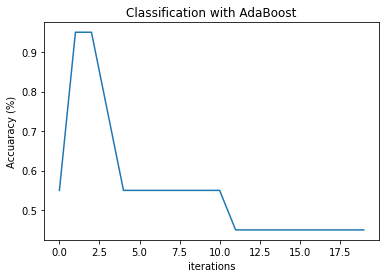

In [7]:
from matplotlib import pyplot as plt

acc = np.zeros(20, )
for M in range(20):
    y_pred_final = adaboost(X_train, y_train, X_test, M)
    acc[M] = np.mean(y_pred_final == y_test)
    
plt.plot(acc)
plt.title('Classification with AdaBoost')
plt.xlabel('iterations')
plt.ylabel('Accuaracy (%)')

It's clear that we boost the performance only for 2 or 3 iterations of the algorithm from **85%** to **90%**